Compitition link:&nbsp;&nbsp; https://www.kaggle.com/competitions/asl-fingerspelling 

References codes:   
·&nbsp; https://www.kaggle.com/code/robikscube/sign-language-recognition-eda-twitch-stream  
（https://www.youtube.com/watch?v=DTQA8KIWWhY）  
·&nbsp; https://www.kaggle.com/code/markwijkhuizen/aslfr-eda-preprocessing-dataset  
·&nbsp; https://www.kaggle.com/code/hebasaleh00/aslfr-eda-preprocessing

In [147]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
base_path='/kaggle/input/asl-fingerspelling/'

In [148]:
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
from scipy.stats import skew, kurtosis

sns.set_palette("colorblind")

In [149]:
# * ploblem : error
# Install nb_black for autoformatting
# !pip install nb_black --quiet
# %load_ext lab_black

# Data EDA

In [150]:
train = pd.read_csv(f'{base_path}/train.csv').head(1000)

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

train.info()
train.head()

N_SAMPLES: 1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            1000 non-null   object
 1   file_id         1000 non-null   int64 
 2   sequence_id     1000 non-null   int64 
 3   participant_id  1000 non-null   int64 
 4   phrase          1000 non-null   object
dtypes: int64(3), object(2)
memory usage: 39.2+ KB


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [151]:
train.isnull().sum()

path              0
file_id           0
sequence_id       0
participant_id    0
phrase            0
dtype: int64

In [152]:
with open(base_path+'character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
      
N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'CHAR2ORD: {CHAR2ORD}\nN_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

# Character to Ordinal Encoding Mapping   
pd.Series(CHAR2ORD).to_frame('Ordinal Encoding').head()

# # Way 2: convert dictionary to pandas dataframe
# CHAR2ORD_DF = pd.DataFrame(CHAR2ORD.values(),index=CHAR2ORD.keys(),columns=['Ordinal Encoding'])
# CHAR2ORD_DF.head()

CHAR2ORD: {' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58}
N_UNIQUE_CHARACTERS: 59


,Ordinal Encoding
,0
!,1
#,2
$,3
%,4


In [153]:
# The way to look at kaggle kernel environment
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
os.environ['KAGGLE_KERNEL_RUN_TYPE'] 

'Interactive'

In [154]:
# Add complete file path to train
def get_file_path(path):
    return f'{base_path}{path}'

train['file_path'] = train['path'].apply(get_file_path)
train.head()

,path,file_id,sequence_id,participant_id,phrase,file_path
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...


In [155]:
"""
The datasets contain addresses/phone numbers/urls (This is written in the official description file)
"""
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)
train.head()


,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address


In [156]:
# Split Phrase To Char Tuple
train['phrase_char'] = train['phrase'].apply(tuple)
# Character Length of Phrase
train['phrase_char_len'] = train['phrase_char'].apply(len)

# Maximum Input Length
MAX_PHRASE_LENGTH = train['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to conveniently lookup recording data
train_sequence_id = train.set_index('sequence_id')

train.head()

MAX_PHRASE_LENGTH: 31


,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,url,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


In [157]:
train[train['phrase_type'].isin(['address'])].head(10)

,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(3, , c, r, e, e, k, h, o, u, s, e)",12
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25
7,train_landmarks/5414471.parquet,5414471,1817171518,202,239613 stolze street,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(2, 3, 9, 6, 1, 3, , s, t, o, l, z, e, , s, ...",20
9,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(2, 7, 1, 0, 9, 7, , b, a, y, s, h, o, r, e, ...",25
10,train_landmarks/5414471.parquet,5414471,1817221592,27,federico pearson,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(f, e, d, e, r, i, c, o, , p, e, a, r, s, o, n)",16
15,train_landmarks/5414471.parquet,5414471,1817348598,20,wildberries_ru,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(w, i, l, d, b, e, r, r, i, e, s, _, r, u)",14
16,train_landmarks/5414471.parquet,5414471,1817362238,231,leona owens,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(l, e, o, n, a, , o, w, e, n, s)",11
17,train_landmarks/5414471.parquet,5414471,1817370426,21,projecteur-led,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(p, r, o, j, e, c, t, e, u, r, -, l, e, d)",14


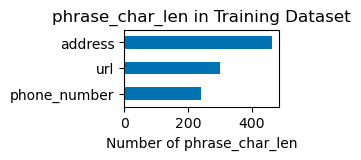

In [158]:
fig, ax = plt.subplots(figsize=(2, 1))
train["phrase_type"].value_counts().sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="phrase_char_len in Training Dataset"
)
ax.set_xlabel("Number of phrase_char_len")

plt.show()


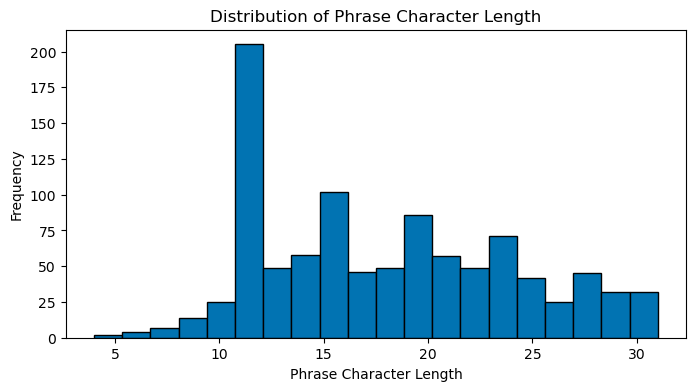

In [159]:
plt.figure(figsize=(8, 4))
plt.hist(train['phrase_char_len'], bins=20, edgecolor='black')  
plt.title('Distribution of Phrase Character Length')
plt.xlabel('Phrase Character Length')
plt.ylabel('Frequency')
plt.show()


# Check out one landmark example from tain


In [160]:
display(train.loc[0],train.loc[0, 'file_path'])

path                                 train_landmarks/5414471.parquet
file_id                                                      5414471
sequence_id                                               1816796431
participant_id                                                   217
phrase                                                  3 creekhouse
file_path          /kaggle/input/asl-fingerspelling/train_landmar...
phrase_type                                                  address
phrase_char                     (3,  , c, r, e, e, k, h, o, u, s, e)
phrase_char_len                                                   12
Name: 0, dtype: object

'/kaggle/input/asl-fingerspelling/train_landmarks/5414471.parquet'

In [161]:
example_landmark = pd.read_parquet(train['file_path'][0])
print(f'# Unique Recording: {example_landmark.index.nunique()}')# Each parquet file contains 1000 recordings

example_landmark.head()

# Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
example_landmark.tail()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1848182207,296,0.657136,0.635888,0.643259,0.619031,0.633084,0.631827,0.630708,0.533120,0.626672,...,-0.143147,-0.139659,-0.066276,-0.130910,-0.127341,-0.106674,-0.083439,-0.124994,-0.119394,-0.101404
1848182207,297,0.655706,0.635570,0.642730,0.618637,0.632830,0.631554,0.630344,0.531868,0.626445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1848182207,298,0.653681,0.636057,0.643054,0.618643,0.633258,0.631800,0.630059,0.531178,0.625990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1848182207,299,0.654293,0.635543,0.642558,0.617969,0.632699,0.631167,0.629263,0.531019,0.625069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1848182207,300,0.655109,0.634491,0.641743,0.617779,0.631771,0.630562,0.629580,0.533534,0.626065,...,-0.196495,-0.202258,-0.101019,-0.179127,-0.182757,-0.169923,-0.116275,-0.173652,-0.176919,-0.167582


In [163]:
example_landmark.shape

(162699, 1630)

In [164]:
unique_sequence_ids = example_landmark.index.unique()
number_of_unique_sequence_ids = len(unique_sequence_ids)
print(f"Number of unique sequence IDs: {number_of_unique_sequence_ids}")

Number of unique sequence IDs: 1000


In [247]:
example_sequence_id=example_landmark.index[0]
#print(example_sequence_id)

example_sequence = example_landmark.loc[example_sequence_id]
number_of_unique_frames = example_sequence['frame'].nunique()

print(f"Number of unique frames for sequence_id 1816796431: {number_of_unique_frames}")
example_sequence.head(2)

Number of unique frames for sequence_id 1816796431: 123


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.26653,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
coordinate_columns = [col for col in example_sequence.columns if col != 'frame']
# Use .copy() to clear the SettingWithCopyWarning
# SettingWithCopyWarning: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
example_sequence=example_sequence.copy()

coordinate_data = example_sequence[coordinate_columns]
print(f'Maximum values:\n{coordinate_data.max().max()}')
print(f'Maximum values:\n{coordinate_data.min().min()}')
print("Number of zeros in the DataFrame:", (coordinate_data == 0).sum().sum())

coordinate_data = coordinate_data.fillna(0.0)

example_sequence.loc[:, coordinate_columns] = coordinate_data
example_sequence.head(2)


Maximum values:
3.156921148300171
Maximum values:
-4.140409469604492
Number of zeros in the DataFrame: 0


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.26653,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


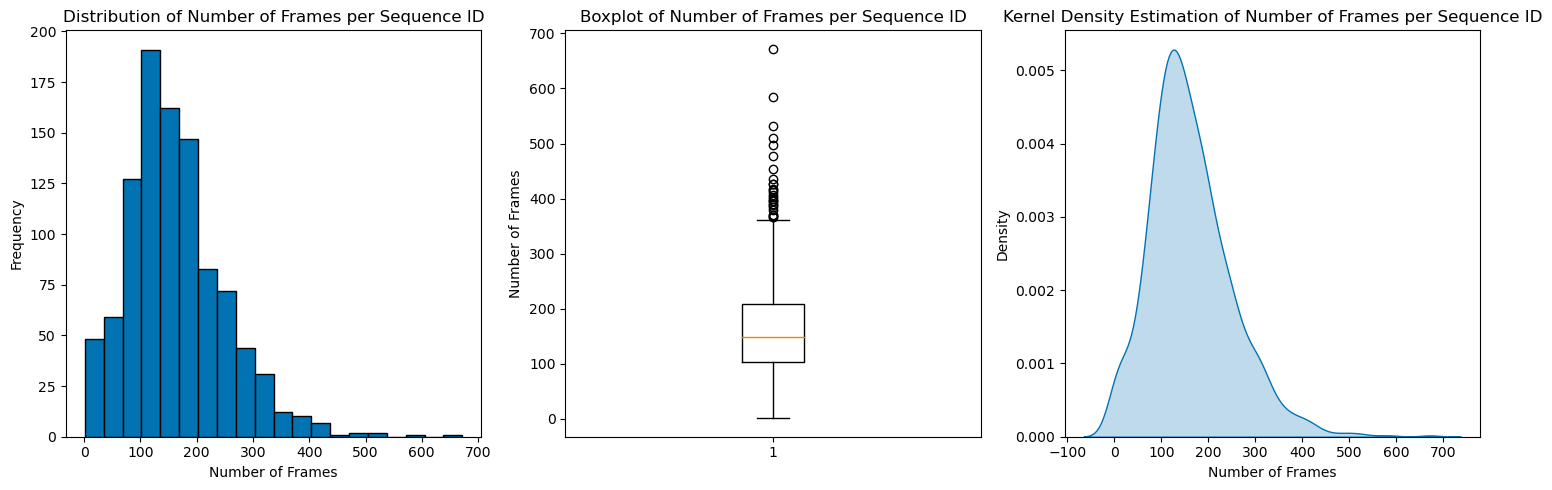

In [166]:
frame_counts = example_landmark.groupby('sequence_id')['frame'].nunique()

plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 3, 1) 
plt.hist(frame_counts, bins=20, edgecolor='black')
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Frames per Sequence ID')

# Boxplot
plt.subplot(1, 3, 2)  
plt.boxplot(frame_counts)
plt.ylabel('Number of Frames')
plt.title('Boxplot of Number of Frames per Sequence ID')

# Kernel Density Estimation Plot
plt.subplot(1, 3, 3) 
sns.kdeplot(frame_counts, fill=True)
plt.xlabel('Number of Frames')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Number of Frames per Sequence ID')

plt.tight_layout()  
plt.show()


# Check out one frame example from example_landmark

In [250]:
example_frame=example_landmark.query("sequence_id == 1816796431 and frame == 25")
print(example_frame.shape)
example_not_nan_col=example_frame.dropna(axis=1)
print(example_not_nan_col.shape)
example_not_nan_col

(1, 1630)
(1, 1567)


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,25,0.699818,0.684874,0.69203,0.678056,0.684491,0.687189,0.696096,0.606068,0.699007,...,-0.133038,-0.150121,-0.078331,-0.150349,-0.168007,-0.164362,-0.102271,-0.167705,-0.177987,-0.173649


In [251]:
# Change some dataframe structure
final_coordinates_list = []

for col_name in example_frame.columns:
    if "_" not in col_name or col_name == 'frame':
        continue

    axis, part, index = col_name.split('_')[0], '_'.join(col_name.split('_')[1:-1]), col_name.split('_')[-1]

    if axis == 'z':
        temp_coordinates = {
            'part': part,
            'x': example_frame[f'x_{part}_{index}'].iloc[0],
            'y': example_frame[f'y_{part}_{index}'].iloc[0],
            'z': example_frame[col_name].iloc[0],
        }
        final_coordinates_list.append(temp_coordinates)


new_df = pd.DataFrame(final_coordinates_list)
new_df.tail()

,part,x,y,z
538,right_hand,0.530677,0.604752,-0.164362
539,right_hand,0.324991,0.631959,-0.102271
540,right_hand,0.390730,0.594926,-0.167705
541,right_hand,0.439991,0.624233,-0.177987
542,right_hand,0.464939,0.657696,-0.173649


In [252]:
import plotly.express as px

fig = px.scatter_3d(new_df, x="x", y="y", z="z", color="part")
fig.update_traces(marker_size = 5)
fig.update_layout(height=600)
fig.show()